# Cuda setup
Check if cuda is available.

In [39]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Import data from source
METHOD 1: install yfinance in the environment hosting python and jupyter. I used Anaconda, and installed through conda terminal into my environment.

*pip install yfinance*

Use the yfinance API to retrieve company data

In [40]:
# yahoo finance api to collect stock data
import yfinance as yf
import os

# datetime imports to work with dates
from datetime import date
from dateutil.relativedelta import relativedelta

# alpaca api to collect stock data
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit

# Process data from csv files
Use pandas library for processing files

Use matplotlib to display graphs and visualizations.

Use torch to create and train a RNN model.

In [41]:
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim.lr_scheduler as lr_scheduler
%matplotlib inline

In [42]:
#Change directory for Lorne's jupyter notebook
# I am mixing windows and wsl on windows so I need to manaually change the directory, so you won't need to when you run it
if True:
    # See files in current directory
    import os

    current_directory = os.getcwd()
    print(current_directory)

    entries = os.listdir('.')
    files = [entry for entry in entries if os.path.isfile(entry)]

    for file_name in files:
        print(file_name)

    %cd "/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS"

    current_directory = os.getcwd()
    print(current_directory)

    entries = os.listdir('.')
    files = [entry for entry in entries if os.path.isfile(entry)]

    # Print the names of the files
    for file_name in files:
        print(file_name)

/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS
AAPL_intraday.csv
AAPL_intraday1.csv
AMD_intraday.csv
AMD_intraday1.csv
first_try.ipynb
model_trained.pt
README.md
RNN.ipynb
/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS
/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS
AAPL_intraday.csv
AAPL_intraday1.csv
AMD_intraday.csv
AMD_intraday1.csv
first_try.ipynb
model_trained.pt
README.md
RNN.ipynb


# Helper functions
StockDataset class to hold pytorch data

In [43]:
training_percentage = 6
valid_percentage = 2
testing_percentage = 2
class StockDataset(torch.utils.data.Dataset[float]):
    def __init__(self, sequences, targets):
        super(StockDataset).__init__()
        self.sequences = sequences
        self.targets = targets
    def __len__(self):
        return len(self.sequences)    
    def __getitem__(self, index):
        sequence = torch.tensor(self.sequences[index], dtype=torch.float32).unsqueeze(-1)#sequence at index 
        target = torch.tensor(self.targets[index], dtype=torch.float32)#test_value at index
        return sequence, target
        
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn1 = nn.RNN(input_size=1, hidden_size=128, num_layers=2, nonlinearity='tanh', bias=True, batch_first=True, dropout=0.0, bidirectional=False, device=None, dtype=None)
        self.fc = nn.Linear(128, 1)
        
    def forward(self, x):
        self.output, self.hidden = self.rnn1(x)
        prediction = self.fc(self.output[:, -1, :])
        return prediction.squeeze(-1)

# get_yahoo_stock_data(name, interval="5m", period="7d")

unction that calls yfinance to get stock data from a defined time period

@params stock_name: name of the stock to get data for

@params interval: interval of the data, default is 15 minutes

@params months: number of months to get data for

In [44]:
# Generate stock price data from yahoo finance 
def get_yahoo_stock_data(name, interval="5m", period="7d"):
    data = yf.download(name, interval=interval, period=period)
    return data

# get_alpaca_stock_data(name, interval="15", months="6") 

function calls alpaca api to get stock data for a defined time period starting from June 1st 2021

@params stock_name: name of the stock to get data for

@params interval: interval of the data, default is 15 minutes

@params months: number of months to get data for

In [45]:
# Generate stock price data from alpaca
def get_alpaca_stock_data(name, interval="15", months="6"):
    name_of_file = name + "_intraday1.csv"

    start_date = date(2021, 6, 1)
    end_date = start_date + relativedelta(months=int(months))  # Adds months

    api = REST('PKJ41QP5QU0TYS4S1BYB', 'o5HVFGx0XWSMoMyeQdRJwG1apYXtuMNcguWpjqqe')

    data = api.get_bars(name, TimeFrame(int(interval), TimeFrameUnit.Minute), start_date, end_date, adjustment='raw').df

    data = data.rename(columns={"close": "Close", "open": "Price", "high": "High", "low": "Low", "volume": "Volume", "datetime": "Datetime", "ticker": "Ticker"})

    data.to_csv(name_of_file)

    return name_of_file

# plot_loss(training_loss_array, validation_loss_array, epochs)

Creates a matplotlib plot of the training and validation loss

@params training_loss_array: Array of training loss values

@params validation_loss_array: Array of validation loss values

@params epochs: Number of epochs

In [46]:
# Creates a matplotlib plot of the training and validation loss
def plot_loss(training_loss_array, validation_loss_array, epochs):
    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot training loss
    plt.plot(range(1, int((epochs)/10) + 1), training_loss_array, marker='o', linestyle='-', color='b', label='Training Loss')

    # Plot validation loss
    plt.plot(range(1, int((epochs)/10) + 1), validation_loss_array, marker='x', linestyle='--', color='r', label='Validation Loss')

    # Add title and labels
    plt.title('Training vs Validation Loss Over Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Add x-axis ticks
    plt.xticks(range(1, (int((epochs + 1)/10)+1), 1))

    # Show the plot
    plt.show()

# plot_target_vs_predicted_values(target_values_array, predicted_values_array, batch_size)

Creates a matplotlib plot of the target values vs the predicted values.

@params target_values_array: Array of actual real values of selected stock for testing phase of RNN

@params predicted_values_array: Array of predicted values generated by RNN

@params batch_size: Number of values in target_values_array and predicted_values_array

In [63]:
# Creates a matplotlib plot of the training and validation loss
def plot_target_vs_predicted_values(target_values_array, predicted_values_array, batch_size):
    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot target values
    plt.plot(range(1, batch_size + 1), target_values_array, marker='o', linestyle='-', color='b', label='Target Values')

    # Plot predicted values
    plt.plot(range(1, batch_size + 1), predicted_values_array, marker='x', linestyle='--', color='r', label='Predicted Values')

    # Add title and labels
    plt.title('Target vs Predicted Stock Values')
    plt.xlabel('Time')
    plt.ylabel('Stock Value')

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Add x-axis ticks
    plt.xticks(range(1, batch_size, 1))

    # Show the plot
    plt.show()

# plot_target_vs_predicted_values(target_values_array, predicted_values_array, batch_size)

Creates a matplotlib plot of the target values vs the predicted values.

@params target_values_array: Array of actual real values of selected stock for testing phase of RNN

@params predicted_values_array: Array of predicted values generated by RNN

@params batch_size: Number of values in target_values_array and predicted_values_array

In [88]:
def standardize_2d(data):
    """
    Standardizes a 2D array of data.
    
    Parameters:
    data (numpy.ndarray): A 2D array of data to be standardized.
    
    Returns:
    numpy.ndarray: The standardized data.
    """
    average_val = np.mean(data)
    std_val = np.std(data)
    standardized_data = (data - average_val) / std_val
    return standardized_data

# Display relevant information for formatting purposes

In [89]:
class RNN_initializer:
    #
    def __init__(self, retrieve, name, recomp, nval, ival, pval, batch_size, num_workers, epochs, learning_rate, lr_scheduler_rate, beta1, beta2):
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.lr_scheduler_rate = lr_scheduler_rate
        self.beta1 = beta1
        self.beta2 = beta2
        if(retrieve == True):
            if (stock_data_source == "yahoo"):
                self.csv_name = self.retrieve_csv(name, recomp, nval, str(ival[0])+ival[1], str(pval[0])+pval[1])
            else:
                self.csv_name = get_alpaca_stock_data(name, stock_interval, stock_period)
        else:
            self.csv_name = name
        self.df=pd.read_csv(name + "_intraday1.csv")
        self.show_df_info()
        #format data, and prepare it for RNN
        if(stock_data_source == "yahoo"):
            price = self.df['Close'].to_list()[2:]
            self.axis_labels = self.df['Price'].to_list()[2:]
        else:
            price = self.df['Close'].to_list()[1:]
            self.axis_labels = self.df['Price'].to_list()[1:]
        date_format_with_time = "%Y-%m-%d %H:%M:%S"
        self.price_inputs = [float(x) for x in price]
        self.price_inputs = standardize_2d(self.price_inputs)
        sequence_length = 4
        #Training sets
        self.train_seq = []
        self.train_tar = []
        #Validation sets
        self.valid_seq = []
        self.valid_tar = []
        #Testing sets
        self.test_seq = []
        self.test_tar = []
        #choose a selected time range
        #NOTE
        train_range = (len(self.price_inputs)//10 * training_percentage)
        print(len(self.price_inputs))
        print(train_range)
        valid_range_beg = train_range
        valid_range_end = train_range + (len(self.price_inputs)//10 * valid_percentage)
        print(valid_range_end)
        test_range_beg = valid_range_end
        test_range_end = valid_range_end + (len(self.price_inputs)//10 * testing_percentage)
        print(test_range_end)
        #generate sequences and targets list for loading data
        for i in range(train_range - sequence_length):
            seq = self.price_inputs[i:i+sequence_length]
            self.train_seq.append(seq)
            temp = self.price_inputs[i+sequence_length]
            self.train_tar.append(temp)
        for j in range(valid_range_beg, valid_range_end-sequence_length):
            seq = self.price_inputs[j:j+sequence_length]
            self.valid_seq.append(seq)
            temp = self.price_inputs[j+sequence_length]
            self.valid_tar.append(temp)
        for k in range(test_range_beg, test_range_end-sequence_length):
            seq = self.price_inputs[k:k+sequence_length]
            self.test_seq.append(seq)
            temp = self.price_inputs[k+sequence_length]
            self.test_tar.append(temp)
        train_data = StockDataset(self.train_seq, self.train_tar)
        valid_data = StockDataset(self.valid_seq, self.valid_tar)
        test_data = StockDataset(self.test_seq, self.test_tar)
        
        self.train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
        self.valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
        self.test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
    # retreive_csv is a file that allows the user to extract stock data from yahoo finance.
    # @param: name, name of file
    # @param: recomp, indicates if file needs to be recompiled
    # @param: num, indicates which file need to be recompiled
    def retrieve_csv(self, name, recomp, nval, ival, pval):
        # Example: Get 1-minute intraday data for Apple (AAPL) for 1 day
        data = get_yahoo_stock_data(stock_name, stock_interval, stock_period)
        ext = ".csv"
        pt2 = "_intraday"
        num = 1;
        file_name = name + pt2 + str(num) + ext
        found = False
        if(recomp!=True):
            while(found!=True):
                if os.path.isfile(file_name):
                    num+=1
                    file_name = name + pt2 + str(num) + ext
                else:
                    found = True
        else:
            if(nval >= 1):
                file_name = name + pt2 + str(nval) + ext
            else:
                file_name = name + pt2 + ext
        data.to_csv(file_name)
        return file_name

    def display_fig(self):
        plt.figure(figsize=(20, 20))
        plt.title(name + " Intraday Stock Price")
        plt.plot(self.axis_labels, self.price_inputs)
        plt.xlabel("time")
        plt.ylabel("price")
        plt.xticks(self.axis_labels[::26])
        plt.yticks(self.price_inputs[::30])
        plt.show()

    def show_df_info(self):
        self.df.head(15)
        self.df.tail(10)
        print("Row count: " + str(len(self.df)))
        
    def trainAndTest(self):
        #RNN model
        self.rnn1 = RNN()
        # move tensors to GPU if CUDA is available
        min_loss = np.inf

        if train_on_gpu:
            self.rnn1.cuda()
        #use MSELoss instead of MSEAbsoluteLoss (predicting next price compared to next change)
        error = nn.MSELoss()
        # specify optimizer
        optimizer = torch.optim.Adam(self.rnn1.parameters(), lr=self.learning_rate, betas=(beta1, beta2))
        #optimizer = optim.SGD(model.parameters(), lr=0.01)
        #self.price_tensor = torch.tensor(self.sequences, dtype=torch.float32).unsqueeze(-1)#input 
        #self.y_tensor = torch.tensor(self.test_vals, dtype=torch.float32)#test_values
        # Learning rate scheduler
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=self.lr_scheduler_rate, patience=10)
        valid_loss_min = np.inf
        for epoch in range(epochs):
            train_loss = 0.0
            valid_loss = 0.0
            #TRAINING
            self.rnn1.train()
            for batch_idx, (data, target) in enumerate(self.train_loader):
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # clear the gradients of all optimized variables
                optimizer.zero_grad()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.rnn1(data)
                # calculate the batch loss
                loss_train = error(output, target)
                # backward pass: compute gradient of the loss with respect to model parameters
                loss_train.backward()
                # perform a single optimization step (parameter update)
                optimizer.step()
                train_loss += loss_train.item()*data.size(0)
                if (loss_train < min_loss):
                    min_loss = loss_train
                    #torch.save(self.rnn1.state_dict(), "rnn1.pth")

            scheduler.step(train_loss)  # Update learning rate

    
            ######################    
            # validate the model #
            ######################
            self.rnn1.eval()
            for batch_idx, (data, target) in enumerate(self.valid_loader):
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.rnn1(data)
                # calculate the batch loss
                loss_valid = error(output, target)
                # perform a single optimization step (parameter update)
                valid_loss += loss_valid.item()*data.size(0)
                if (loss_valid < min_loss):
                    min_loss = loss_valid
                    #torch.save(self.rnn1.state_dict(), "rnn1.pth")
            # calculate average losses
            train_loss = train_loss/len(self.train_loader.dataset)
            valid_loss = valid_loss/len(self.valid_loader.dataset)
            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min and (epoch+1) % 10 == 0:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(self.rnn1.state_dict(), 'model_trained.pt')
                valid_loss_min = valid_loss

            if (epoch+1) % 10 == 0:
                lr = optimizer.param_groups[0]["lr"]
                print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss_train.item():.6f}, Validation Loss: {loss_valid.item():.6f}")
                training_loss_array.append(int(loss_train.item()))
                validation_loss_array.append(int(loss_valid.item()))
        return min_loss
        


In [48]:
#Stock variables used when collecting stock data
#Choose which api to use to grab stock data, either "yahoo" or "alpaca"
stock_data_source = "alpaca"

#Loss array used to store loss values for each 10 epochs, reset each set of hyperparameters
training_loss_array = []
validation_loss_array = []
test_loss = np.inf

#Stock variables when using yahoo finance api
if stock_data_source == "yahoo":
    stock_name = "AMD"
    stock_interval="5m"
    stock_period="7d"
    epochs = 100
    lr_scheduler_rate = 0.8
    beta1 = 0.9
    beta2 = 0.999

#Stock variables when using alpaca api
if stock_data_source == "alpaca":
    stock_name = "AMD"
    stock_interval="15"
    stock_period="12" #months
    epochs = 150
    lr_scheduler_rate = 0.1
    beta1 = 0.95
    beta2 = 0.999

batch_size = 16
num_workers = 0

Row count: 15624
15623
9372
12496
15620


-------------------------------------------------------------------------------
Learning rate:  0.005    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 15624
15623
9372
12496
15620
Validation loss decreased (inf --> 758.863490).  Saving model ...
Epoch 10/150, Training Loss: 75.071632, Validation Loss: 809.493286
Epoch 20/150, Training Loss: 75.677582, Validation Loss: 811.567749
Validation loss decreased (758.863490 --> 171.411816).  Saving model ...
Epoch 30/150, Training Loss: 71.891235, Validation Loss: 128.303986
Validation loss decreased (171.411816 --> 123.232670).  Saving model ...
Epoch 40/150, Training Loss: 144.297546, Validation Loss: 60.776268
Validation loss decreased (123.232670 --> 99.441392).  Saving model ...
Epoch

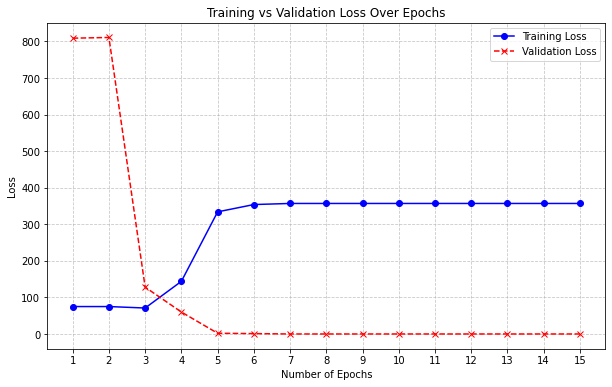



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 15624
15623
9372
12496
15620
Validation loss decreased (inf --> 246.506978).  Saving model ...
Epoch 10/150, Training Loss: 24.062243, Validation Loss: 223.177460
Validation loss decreased (246.506978 --> 121.923319).  Saving model ...
Epoch 20/150, Training Loss: 146.224121, Validation Loss: 58.782040
Validation loss decreased (121.923319 --> 5.630967).  Saving model ...
Epoch 30/150, Training Loss: 15.015610, Validation Loss: 5.395746
Epoch 40/150, Training Loss: 86.498703, Validation Loss: 208.153809
Epoch 50/150, Training Loss: 17.732063, Validation Loss: 62.047707
Epoch 60/150, Training Loss: 84.485420, Validation Los

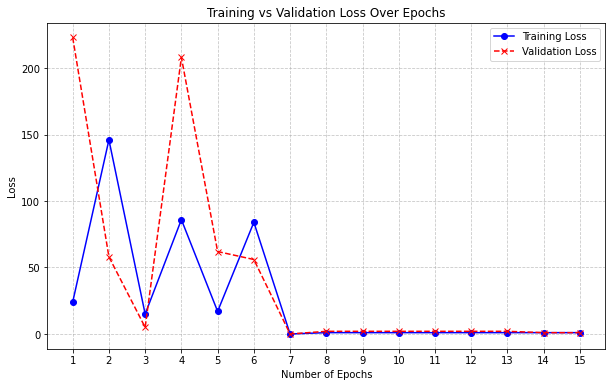



-------------------------------------------------------------------------------
Learning rate:  0.0005    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 15624
15623
9372
12496
15620
Validation loss decreased (inf --> 113.499154).  Saving model ...
Epoch 10/150, Training Loss: 171.396973, Validation Loss: 45.130737
Validation loss decreased (113.499154 --> 101.593426).  Saving model ...
Epoch 20/150, Training Loss: 225.571487, Validation Loss: 22.451160
Validation loss decreased (101.593426 --> 49.362705).  Saving model ...
Epoch 30/150, Training Loss: 8.533161, Validation Loss: 76.536728
Validation loss decreased (49.362705 --> 36.143369).  Saving model ...
Epoch 40/150, Training Loss: 69.588821, Validation Loss: 18.856800
Validation loss decreased (36.143369 --> 18.24720

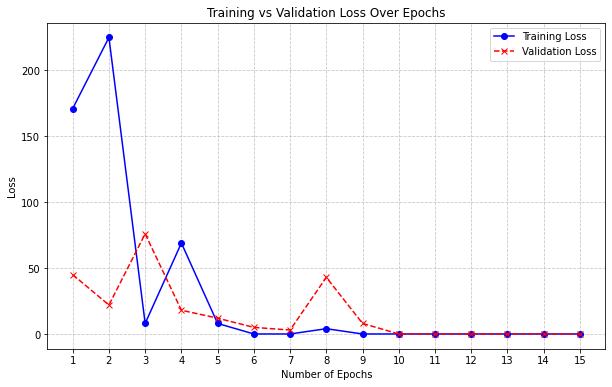



-------------------------------------------------------------------------------
Learning rate:  0.0001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 15624
15623
9372
12496
15620
Validation loss decreased (inf --> 2274.260932).  Saving model ...
Epoch 10/150, Training Loss: 4051.897705, Validation Loss: 1928.922852
Validation loss decreased (2274.260932 --> 158.418813).  Saving model ...
Epoch 20/150, Training Loss: 614.724976, Validation Loss: 25.750134
Validation loss decreased (158.418813 --> 150.163140).  Saving model ...
Epoch 30/150, Training Loss: 95.294327, Validation Loss: 99.849205
Epoch 40/150, Training Loss: 19.203022, Validation Loss: 162.423523
Validation loss decreased (150.163140 --> 123.157697).  Saving model ...
Epoch 50/150, Training Loss: 90.967606,

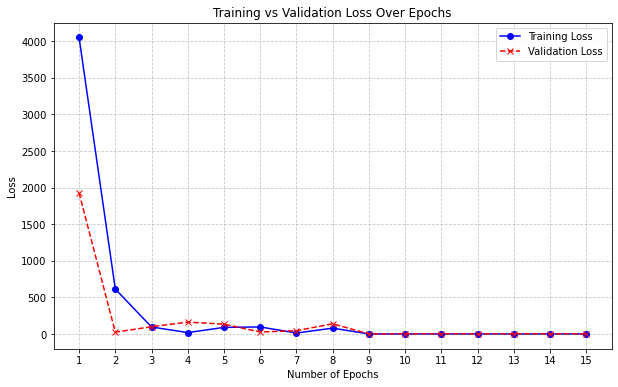



-------------------------------------------------------------------------------
Learning rate:  5e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 15624
15623
9372
12496
15620
Validation loss decreased (inf --> 6022.484008).  Saving model ...
Epoch 10/150, Training Loss: 8829.525391, Validation Loss: 5511.242676
Validation loss decreased (6022.484008 --> 2109.211394).  Saving model ...
Epoch 20/150, Training Loss: 3824.663574, Validation Loss: 1773.743408
Validation loss decreased (2109.211394 --> 465.263908).  Saving model ...
Epoch 30/150, Training Loss: 1308.062622, Validation Loss: 270.309204
Validation loss decreased (465.263908 --> 144.820930).  Saving model ...
Epoch 40/150, Training Loss: 569.187500, Validation Loss: 17.232828
Validation loss decreased (144.8

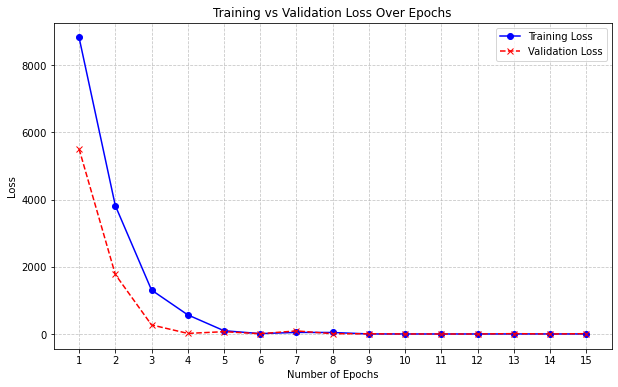



-------------------------------------------------------------------------------
Learning rate:  1e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 15624
15623
9372
12496
15620
Validation loss decreased (inf --> 11289.327291).  Saving model ...
Epoch 10/150, Training Loss: 15074.179688, Validation Loss: 10620.398438
Validation loss decreased (11289.327291 --> 9802.249409).  Saving model ...
Epoch 20/150, Training Loss: 13339.841797, Validation Loss: 9173.148438
Validation loss decreased (9802.249409 --> 8430.139020).  Saving model ...
Epoch 30/150, Training Loss: 11722.140625, Validation Loss: 7840.596680
Validation loss decreased (8430.139020 --> 7170.406125).  Saving model ...
Epoch 40/150, Training Loss: 10218.400391, Validation Loss: 6620.166992
Validation loss de

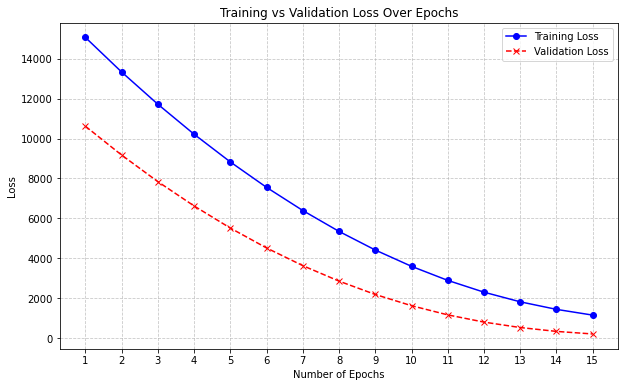



Best learning rate:  0.0005    Loss:  tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)
Second best learning rate:  0.0001    Loss:  tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


In [49]:
#test various learning rates
learning_rate_list = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001] #revert later for hyperparameter testing, the first few values are not good current set of hyperparameters
#learning_rate_list = [0.0005, 0.0001, 0.00005, 0.00001]
best_lr = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
best_lr_in_loop = np.inf
repeated_loops_per_lr = 1
rnnControl = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], 
                             batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=0.001, lr_scheduler_rate=lr_scheduler_rate,
                             beta1=beta1, beta2=beta2)
bestRNN = [rnnControl,None]
bestRNN_in_loop = rnnControl
for lr in learning_rate_list:
    print("\n\n-------------------------------------------------------------------------------")
    print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
    print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
    print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
    print("Learning rate scheduler rate: ", lr_scheduler_rate)
    print("Beta1: ", beta1, "Beta2: ", beta2)
    print("-------------------------------------------------------------------------------")
    
    for i in range(repeated_loops_per_lr):
        rnn1 = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        #returns
        training_loss_array = []
        validation_loss_array = []
        loss = rnn1.trainAndTest()
        if best_lr_in_loop > loss:
            best_lr_in_loop = loss
            bestRNN_in_loop = rnn1
    #if found best lr, remove worst lr from list
    if best_lr_in_loop < best_lr[0][0]:
        best_lr[1] = best_lr[0]
        best_lr[0] = [best_lr_in_loop, lr]
        bestRNN[1] = bestRNN[0]
        bestRNN[0] = bestRNN_in_loop
        #if 
    elif best_lr_in_loop < best_lr[1][0]:
        best_lr[1] = [best_lr_in_loop, lr]
        bestRNN[1] = bestRNN_in_loop
    best_lr_in_loop = np.inf

    plot_loss(training_loss_array, validation_loss_array, epochs)

print("\n\nBest learning rate: ", best_lr[0][1], "   Loss: ", best_lr[0][0])
print("Second best learning rate: ", best_lr[1][1], "   Loss: ", best_lr[1][0])





-------------------------------------------------------------------------------
Learning rate:  0.0005    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 15624
15623
9372
12496
15620
Validation loss decreased (inf --> 119.521669).  Saving model ...
Epoch 10/150, Training Loss: 153.591949, Validation Loss: 54.973358
Validation loss decreased (119.521669 --> 99.198876).  Saving model ...
Epoch 20/150, Training Loss: 250.004913, Validation Loss: 15.647161
Validation loss decreased (99.198876 --> 55.895368).  Saving model ...
Epoch 30/150, Training Loss: 92.460030, Validation Loss: 65.827148
Validation loss decreased (55.895368 --> 19.446815).  Saving model ...
Epoch 40/150, Training Loss: 11.832933, Validation Loss: 13.121130
Epoch 50/150, Training Loss: 46.449490, Validation

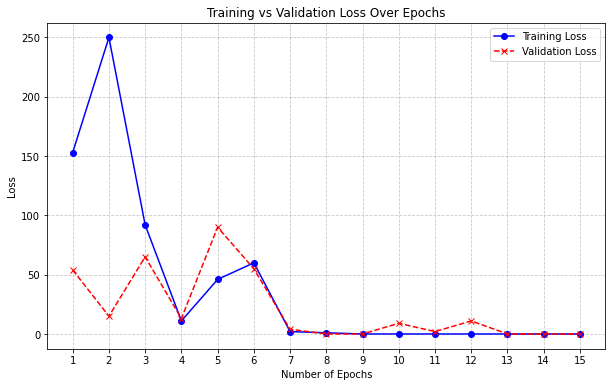



-------------------------------------------------------------------------------
Learning rate:  0.00046    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 15624
15623
9372
12496
15620
Validation loss decreased (inf --> 111.739734).  Saving model ...
Epoch 10/150, Training Loss: 177.311340, Validation Loss: 42.121071
Epoch 20/150, Training Loss: 162.294220, Validation Loss: 49.933746
Validation loss decreased (111.739734 --> 98.080464).  Saving model ...
Epoch 30/150, Training Loss: 270.794586, Validation Loss: 10.999033
Validation loss decreased (98.080464 --> 72.580020).  Saving model ...
Epoch 40/150, Training Loss: 14.862128, Validation Loss: 129.534515
Validation loss decreased (72.580020 --> 3.995806).  Saving model ...
Epoch 50/150, Training Loss: 6.783067, Validatio

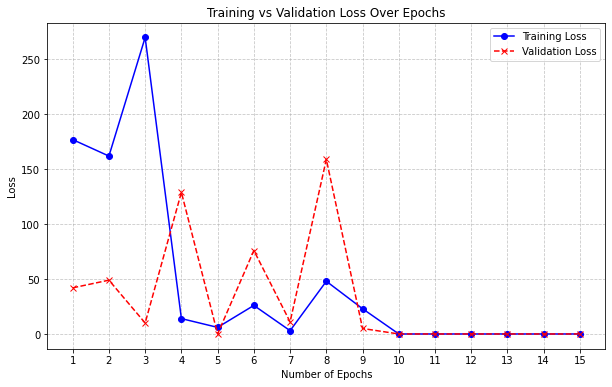



-------------------------------------------------------------------------------
Learning rate:  0.00042    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 15624
15623
9372
12496
15620
Validation loss decreased (inf --> 97.980489).  Saving model ...
Epoch 10/150, Training Loss: 275.778259, Validation Loss: 10.345074
Epoch 20/150, Training Loss: 249.266678, Validation Loss: 15.822856
Validation loss decreased (97.980489 --> 47.162426).  Saving model ...
Epoch 30/150, Training Loss: 60.920082, Validation Loss: 72.360466
Validation loss decreased (47.162426 --> 4.861662).  Saving model ...
Epoch 40/150, Training Loss: 7.348235, Validation Loss: 0.773899
Epoch 50/150, Training Loss: 40.741264, Validation Loss: 43.843044
Epoch 60/150, Training Loss: 34.263382, Validation Loss: 1

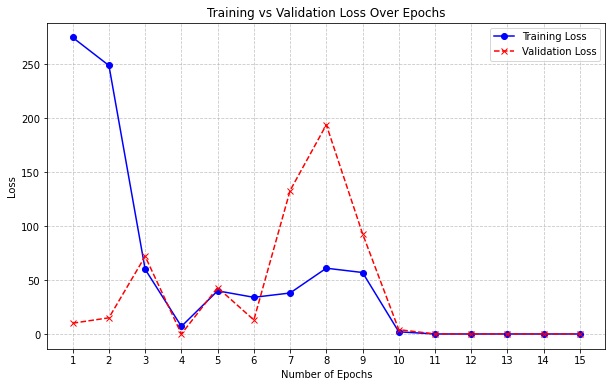



-------------------------------------------------------------------------------
Learning rate:  0.00038    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 15624
15623
9372
12496
15620
Validation loss decreased (inf --> 100.863249).  Saving model ...
Epoch 10/150, Training Loss: 353.466309, Validation Loss: 1.201386
Validation loss decreased (100.863249 --> 100.242888).  Saving model ...
Epoch 20/150, Training Loss: 238.131744, Validation Loss: 18.762798
Validation loss decreased (100.242888 --> 73.972171).  Saving model ...
Epoch 30/150, Training Loss: 71.480652, Validation Loss: 86.729248
Validation loss decreased (73.972171 --> 4.060315).  Saving model ...
Epoch 40/150, Training Loss: 8.240298, Validation Loss: 0.754387
Epoch 50/150, Training Loss: 30.976267, Validation 

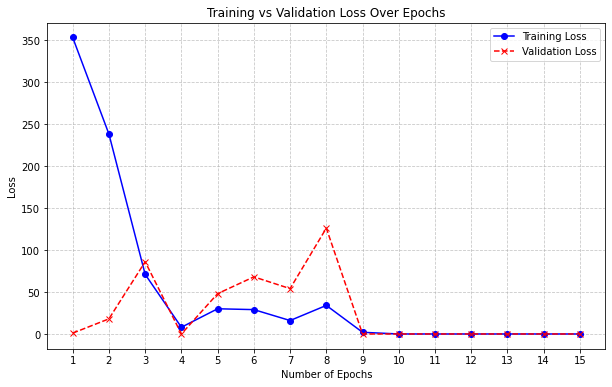



-------------------------------------------------------------------------------
Learning rate:  0.00034    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 15624
15623
9372
12496
15620
Validation loss decreased (inf --> 99.555127).  Saving model ...
Epoch 10/150, Training Loss: 246.697083, Validation Loss: 16.776901
Validation loss decreased (99.555127 --> 97.784508).  Saving model ...
Epoch 20/150, Training Loss: 289.601257, Validation Loss: 7.618217
Validation loss decreased (97.784508 --> 72.371373).  Saving model ...
Epoch 30/150, Training Loss: 160.091995, Validation Loss: 38.311298
Validation loss decreased (72.371373 --> 1.697264).  Saving model ...
Epoch 40/150, Training Loss: 4.668872, Validation Loss: 1.466092
Epoch 50/150, Training Loss: 44.075108, Validation Los

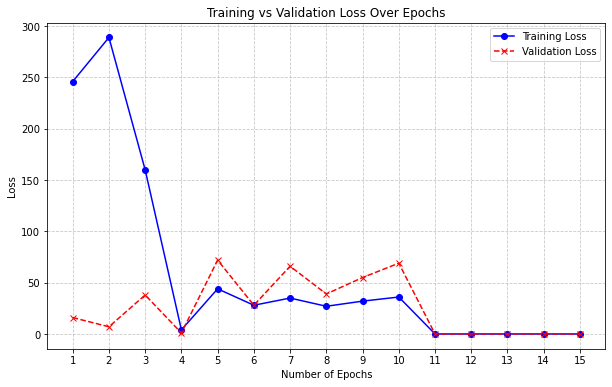



-------------------------------------------------------------------------------
Learning rate:  0.00030000000000000003    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 15624
15623
9372
12496
15620
Validation loss decreased (inf --> 97.784109).  Saving model ...
Epoch 10/150, Training Loss: 290.126221, Validation Loss: 7.718994
Epoch 20/150, Training Loss: 468.454895, Validation Loss: 3.737419
Epoch 30/150, Training Loss: 433.148438, Validation Loss: 1.404347
Epoch 40/150, Training Loss: 431.260986, Validation Loss: 1.317545
Epoch 50/150, Training Loss: 431.425079, Validation Loss: 1.326853
Epoch 60/150, Training Loss: 431.455688, Validation Loss: 1.328529
Epoch 70/150, Training Loss: 431.441833, Validation Loss: 1.327841
Epoch 80/150, Training Loss: 431.441864, Validatio

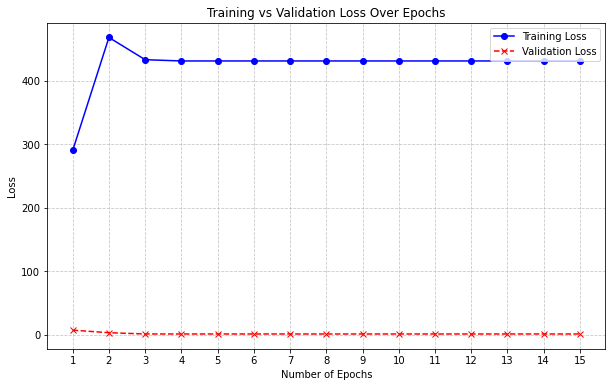



-------------------------------------------------------------------------------
Learning rate:  0.00026    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 15624
15623
9372
12496
15620
Validation loss decreased (inf --> 102.881177).  Saving model ...
Epoch 10/150, Training Loss: 371.883606, Validation Loss: 0.467391
Epoch 20/150, Training Loss: 149.852997, Validation Loss: 58.924061
Epoch 30/150, Training Loss: 427.663940, Validation Loss: 1.182938
Validation loss decreased (102.881177 --> 10.102376).  Saving model ...
Epoch 40/150, Training Loss: 7.771226, Validation Loss: 4.018203
Epoch 50/150, Training Loss: 23.192141, Validation Loss: 16.230564
Epoch 60/150, Training Loss: 24.870342, Validation Loss: 36.479950
Epoch 70/150, Training Loss: 18.822414, Validation Loss: 36.

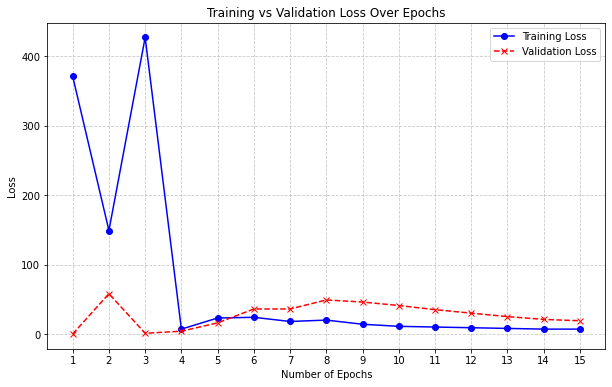



-------------------------------------------------------------------------------
Learning rate:  0.00021999999999999998    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 15624
15623
9372
12496
15620
Validation loss decreased (inf --> 138.307242).  Saving model ...
Epoch 10/150, Training Loss: 546.933960, Validation Loss: 13.414376
Validation loss decreased (138.307242 --> 98.605917).  Saving model ...
Epoch 20/150, Training Loss: 259.771576, Validation Loss: 13.506180
Epoch 30/150, Training Loss: 420.078674, Validation Loss: 0.986833
Validation loss decreased (98.605917 --> 37.814352).  Saving model ...
Epoch 40/150, Training Loss: 60.353962, Validation Loss: 52.004078
Validation loss decreased (37.814352 --> 9.016091).  Saving model ...
Epoch 50/150, Training Loss: 0.3425

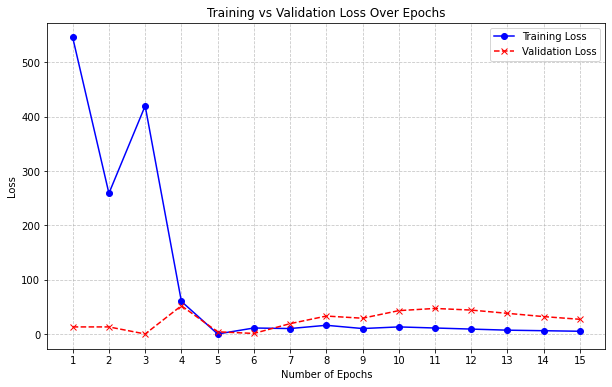



-------------------------------------------------------------------------------
Learning rate:  0.00017999999999999998    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 15624
15623
9372
12496
15620
Validation loss decreased (inf --> 288.849502).  Saving model ...
Epoch 10/150, Training Loss: 950.950439, Validation Loss: 123.153610
Validation loss decreased (288.849502 --> 100.311799).  Saving model ...
Epoch 20/150, Training Loss: 346.294495, Validation Loss: 1.550942
Epoch 30/150, Training Loss: 210.366409, Validation Loss: 27.800016
Epoch 40/150, Training Loss: 417.713928, Validation Loss: 0.740384
Validation loss decreased (100.311799 --> 53.062194).  Saving model ...
Epoch 50/150, Training Loss: 10.079897, Validation Loss: 54.482727
Validation loss decreased (53.06219

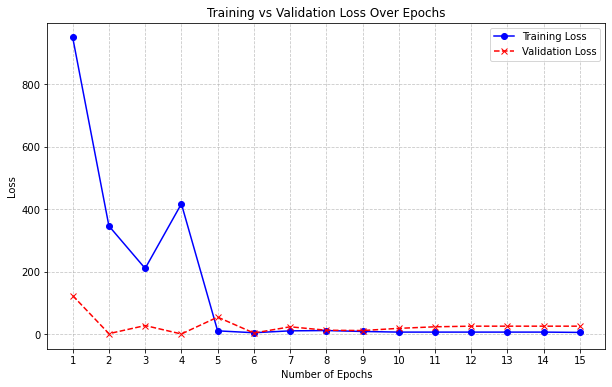



-------------------------------------------------------------------------------
Learning rate:  0.00014    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 15624
15623
9372
12496
15620
Validation loss decreased (inf --> 848.125371).  Saving model ...
Epoch 10/150, Training Loss: 1971.426270, Validation Loss: 608.177673
Validation loss decreased (848.125371 --> 107.192768).  Saving model ...
Epoch 20/150, Training Loss: 403.246277, Validation Loss: 0.348489
Epoch 30/150, Training Loss: 46.347374, Validation Loss: 167.916397
Validation loss decreased (107.192768 --> 97.832164).  Saving model ...
Epoch 40/150, Training Loss: 297.099609, Validation Loss: 6.551419
Epoch 50/150, Training Loss: 340.658325, Validation Loss: 1.842289
Epoch 60/150, Training Loss: 393.193115, Validati

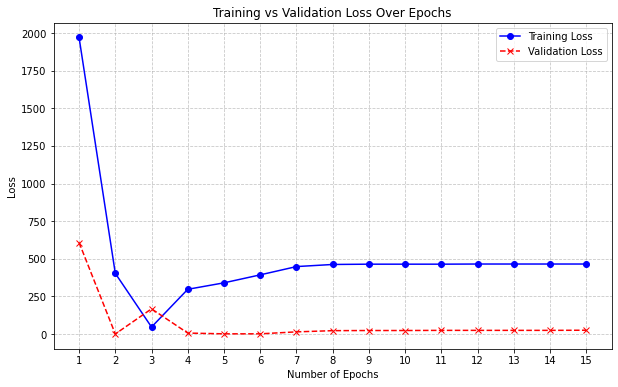



Best learning rate:  0.00042    Loss:  tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)
Second best learning rate:  0.00017999999999999998    Loss:  tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


In [50]:
learning_rate_list = []
difference_of_lr = best_lr[0][1] - best_lr[1][1]
number_of_increments = 10
increment = difference_of_lr / number_of_increments

for i in range(number_of_increments):
    learning_rate_list.append(best_lr[0][1] - increment * i)

for lr in learning_rate_list:
    print("\n\n-------------------------------------------------------------------------------")
    print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
    print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
    print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
    print("Learning rate scheduler rate: ", lr_scheduler_rate)
    print("Beta1: ", beta1, "Beta2: ", beta2)
    print("-------------------------------------------------------------------------------")

    
    
    for i in range(repeated_loops_per_lr):
        training_loss_array = []
        validation_loss_array = []
        rnn1 = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        loss = rnn1.trainAndTest()
        if best_lr_in_loop > loss:
            best_lr_in_loop = loss

    if best_lr_in_loop < best_lr[0][0]:
        best_lr[1] = best_lr[0]
        best_lr[0] = [best_lr_in_loop, lr]
    elif best_lr_in_loop < best_lr[1][0]:
        best_lr[1] = [best_lr_in_loop, lr]

    best_lr_in_loop = np.inf


    plot_loss(training_loss_array, validation_loss_array, epochs)


print("\n\nBest learning rate: ", best_lr[0][1], "   Loss: ", best_lr[0][0])
print("Second best learning rate: ", best_lr[1][1], "   Loss: ", best_lr[1][0])

In [51]:
#if stock_data_source == "yahoo":
    #Stock variables when using yahoo finance api
#    stock_name = "AMD"
#    stock_interval="5m"
#    stock_period="7d"
#    epochs = 100
#    lr_scheduler_rate = 0.8
#    beta1 = 0.9
#    beta2 = 0.999

#Stock variables when using alpaca api
#if stock_data_source == "alpaca":
#    stock_name = "AMD"
#    stock_interval="15"
#    stock_period="24" #months
#    epochs = 200
#    lr_scheduler_rate = 0.1
#    beta1 = 0.95
#    beta2 = 0.999

#batch_size = 16
#num_workers = 0

In [52]:

#test previous god perfoming rates learning rates
#learning_rate_list = [0.00018, 0.00016, 0.00014, 0.00012]
#best_lr = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
#best_lr_in_loop = np.inf
#repeated_loops_per_lr = 3

#for lr in learning_rate_list:
#    print("\n\n-------------------------------------------------------------------------------")
#    print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
#    print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
#    print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
#    print("Learning rate scheduler rate: ", lr_scheduler_rate)
#    print("Beta1: ", beta1, "Beta2: ", beta2)
#    print("-------------------------------------------------------------------------------")
    
#    for i in range(repeated_loops_per_lr):
#        training_loss_array = []
#        validation_loss_array = []
#        rnn1 = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
#        loss = rnn1.trainAndTest()
#        if best_lr_in_loop > loss:
#            best_lr_in_loop = loss

#    if best_lr_in_loop < best_lr[0][0]:
#        best_lr[1] = best_lr[0]
#        best_lr[0] = [best_lr_in_loop, lr]
#    elif best_lr_in_loop < best_lr[1][0]:
#        best_lr[1] = [best_lr_in_loop, lr]

#    plot_loss(training_loss_array, validation_loss_array, epochs)

In [53]:
#output,hidden = rnn1(price_tensor)
#print(output.shape)  # (1, 1, 128)
#print(hidden.shape)  # (2, 1, 128)
  # Predict 1 value from hidden_size=128

#prediction = fc(output[:, -1, :])  # Take output at last time step
#print(prediction)

## Test the Trained Network
---
Test your trained model on previously unseen data! Remember we have downloaded `train_data` and `test_data`. We will use `test_data` through `test_loader`.

A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

The following is working code, but you are encouraged to make your own adjustments and enhance the implementation.

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)
---
Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

The following is working code, but you can make your own adjustments.

**TODO**: try to compare with ADAM optimizer

In [54]:
#error = nn.MSELoss()
#optimizer = torch.optim.Adam(prediction.parameters(), lr=0.001)

#epochs = 50
#for epoch in range(epochs):
#    rnn1.train()
#    fc.train()
    
#      output,hidden = rnn1(price_tensor)
#    prediction = fc(output[:, -1, :])
#    loss = error(prediction, y_tensor)
    
#    optimizer.zero_grad()
#    loss.backward()
#    optimizer.step()

#    if (epoch+1) % 10 == 0:
#        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

In [55]:
test_loss = 0.0
value_correct = 0
error = nn.MSELoss()

bestRNN[0].rnn1.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(bestRNN[0].test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = bestRNN[0].rnn1(data)
    # calculate the batch loss
    loss = error(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # compare predictions to true label
    correct_tensor = output.eq(target.data.view_as(output))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    value_correct += 1
        
# average test loss
test_loss = test_loss/len(bestRNN[0].test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('Test Accuracy: %2d%% (%2d/%2d)' % (test_loss,
    value_correct, len(bestRNN[0].test_loader.dataset)))

Test Loss: 0.695156

Test Accuracy:  0% (195/3120)




-------------------------------------------------------------------------------
Target Values vs Predicted Values: 
Stock:  AMD
Batch size:  16
Target Values  [101.98300170898438, 102.08999633789062, 101.20999908447266, 101.13999938964844, 101.16000366210938, 101.0999984741211, 101.0999984741211, 101.10009765625, 101.18000030517578, 101.16999816894531, 101.04000091552734, 101.05999755859375, 101.16999816894531, 101.06999969482422, 101.02999877929688, 100.9800033569336]
Output Values  [102.9495849609375, 102.81329345703125, 102.88652038574219, 102.20066833496094, 101.99331665039062, 101.93411254882812, 101.88706970214844, 101.87763977050781, 101.87330627441406, 101.9361572265625, 101.94291687011719, 101.84503173828125, 101.83596801757812, 101.91648864746094, 101.85984802246094, 101.81819152832031]
Test Loss:  0.6951559715546094
-------------------------------------------------------------------------------


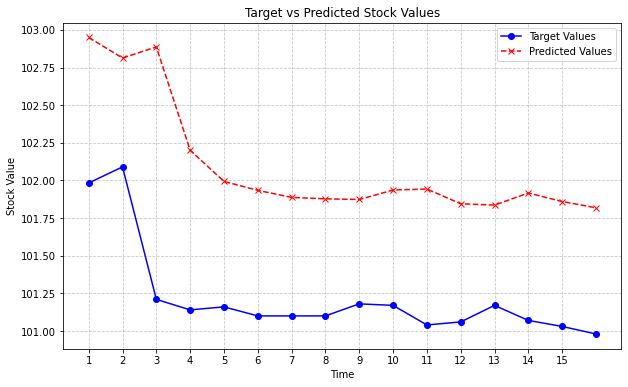

In [67]:
target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

print("\n\n-------------------------------------------------------------------------------")
print("Target Values vs Predicted Values: ")
print("Stock: ", stock_name)
print("Batch size: ", batch_size)
print("Target Values ", target_array)
print("Output Values ", output_array)
print("Test Loss: ", test_loss)
print("-------------------------------------------------------------------------------")

plot_target_vs_predicted_values(target_array, output_array, batch_size)



-------------------------------------------------------------------------------
Normalized target values and predicted values: 
Shifted predicted values 1 to the left
Target differnce of begining and end stock price: $ -1.0029983520507812
Predicted differnce of begining and end stock price: $ -0.9951019287109375
-------------------------------------------------------------------------------


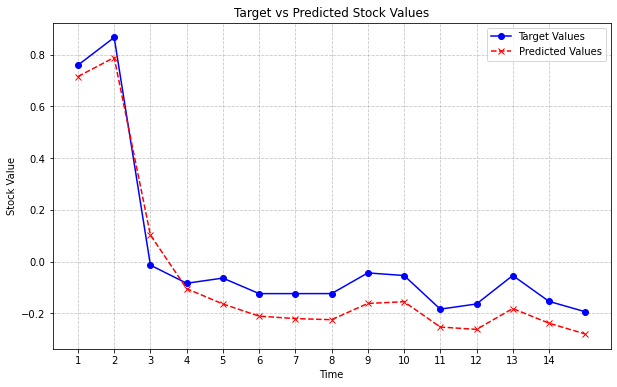

In [ ]:
target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

target_sum = 0
for i in target_array:
    target_sum += i
target_average = target_sum / len(target_array)

for i in range(len(target_array)):
    target_array[i] -= target_average

output_sum = 0
for i in output_array:
    output_sum += i
output_average = output_sum / len(output_array)

for i in range(len(output_array)):
    output_array[i] -= output_average

for i in range(len(output_array) - 1):
    output_array[i] = output_array[i + 1]

print("\n\n-------------------------------------------------------------------------------")
print("Normalized mean target values and predicted values to equal 0: ")
print("Shifted predicted values 1 to the left")
print("Target differnce of begining and end stock price: $", target_array[-1] - target_array[0])
print("Predicted differnce of begining and end stock price: $", output_array[-1] - output_array[0])
print("-------------------------------------------------------------------------------")



plot_target_vs_predicted_values(target_array[0:batch_size-1], output_array[0:batch_size-1], batch_size - 1)



tensor([116.3039, 116.2580, 116.3409, 117.0411, 117.5709, 117.7135, 117.3920,
        117.4984, 117.5499, 117.5122, 117.5591, 117.2513, 117.3053, 117.3891,
        116.7665, 116.8015], device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([115.4000, 115.5000, 116.3500, 116.8000, 116.8800, 116.4600, 116.7100,
        116.7000, 116.6600, 116.7300, 116.3200, 116.5000, 116.5500, 115.7500,
        116.0100, 116.1100], device='cuda:0')
Output shape: torch.Size([16])
Target shape: torch.Size([16])
Test Loss: 0.792125



-------------------------------------------------------------------------------
Target Values vs Predicted Values: 
Stock:  AMD
Batch size:  16
Target Values  [115.4000015258789, 115.5, 116.3499984741211, 116.80000305175781, 116.87999725341797, 116.45999908447266, 116.70999908447266, 116.69999694824219, 116.66000366210938, 116.7300033569336, 116.31999969482422, 116.5, 116.55000305175781, 115.75, 116.01000213623047, 116.11000061035156]
Output Values  [116.30390930175781, 116.2579

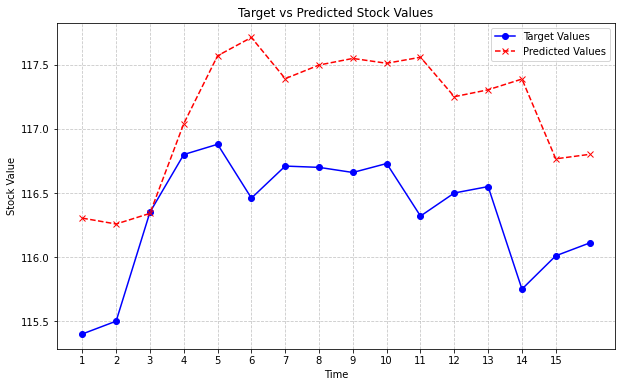



-------------------------------------------------------------------------------
Normalized target values and predicted values: 
Shifted predicted values 1 to the left
Target differnce of begining and end stock price: $ 0.7099990844726562
Predicted differnce of begining and end stock price: $ 0.54351806640625
-------------------------------------------------------------------------------


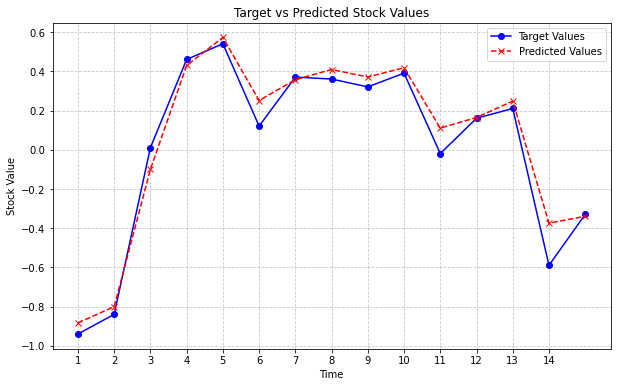

In [ ]:
total_loss = 0
#iterate over test data
test_data = iter(bestRNN[0].test_loader)
data, target = next(test_data)
if train_on_gpu:
    data, target = data.cuda(), target.cuda()
#forward pass: compute predicted outputs by passing inputs to the model
output = bestRNN[0].rnn1(data)
print(output)
print(target)
print("Output shape:", output.shape)
print("Target shape:", target.shape)
#calculate the batch loss
loss = error(output, target)
#update test loss
total_loss += loss.item()
test_loss += loss.item()/batch_size
#calculate test accuracy for each object class
#value_correct += 1

#average test loss
#test_loss = test_loss/len(bestRNN[0].test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

print("\n\n-------------------------------------------------------------------------------")
print("Target Values vs Predicted Values: ")
print("Stock: ", stock_name)
print("Batch size: ", batch_size)
print("Target Values ", target_array)
print("Output Values ", output_array)
print("Test Loss: ", test_loss)
print("-------------------------------------------------------------------------------")

plot_target_vs_predicted_values(target_array, output_array, batch_size)

target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

target_sum = 0
for i in target_array:
    target_sum += i
target_average = target_sum / len(target_array)

for i in range(len(target_array)):
    target_array[i] -= target_average

output_sum = 0
for i in output_array:
    output_sum += i
output_average = output_sum / len(output_array)

for i in range(len(output_array)):
    output_array[i] -= output_average

for i in range(len(output_array) - 1):
    output_array[i] = output_array[i + 1]

print("\n\n-------------------------------------------------------------------------------")
print("Normalized mean target values and predicted values to equal 0: ")
print("Shifted predicted values 1 to the left")
print("Target differnce of begining and end stock price: $", target_array[-1] - target_array[0])
print("Predicted differnce of begining and end stock price: $", output_array[-1] - output_array[0])
print("-------------------------------------------------------------------------------")



plot_target_vs_predicted_values(target_array[0:batch_size-1], output_array[0:batch_size-1], batch_size - 1)
